# Import libraries

In [1]:
import numpy as np  
import matplotlib.pyplot as plt
from vmdpy import VMD  
import pandas as pd
from vmd_post_func import *
import seaborn as sns
from scipy.signal import find_peaks,peak_widths
import itertools
from vmd_optim import *

# Seaborn Plot Inputs:

In [2]:
plot_style = {
    'font.size': 22.0,
    'font.family':'Times New Roman',
    'axes.labelsize': 20,
    'axes.titlesize': 30,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'axes.linewidth': 1.5,
    'axes.grid': True,
    'grid.linestyle':'--',
    'grid.linewidth': 1,
    'lines.linewidth': 2,
    'lines.markersize': 8.0,
    'patch.linewidth': 1.0,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'ytick.minor.width': 0.6,
    'xtick.major.size': 5.5,
    'ytick.major.size': 5.5,
    'xtick.minor.size': 2.0,
    'ytick.minor.size': 2.0,
    'legend.title_fontsize': None
}
sns.set_context(plot_style)

# Inputs:

In [57]:
# Inputs:
low_freq = 50 # low frequency cut-off in Hz
freq_res = 0.1 # frequency resolution in Hz
fs = 1000 # sampling frequency
file_ID = 1 # first csv file number to extract data
num_peaks = 5 # number peaks to pick
num_passes = 10 # number of vehicle passes on bridge
veh_col_idx = 2
# file inputs:
file_path = '../../parametric_study/case_studies/Rob_CNN/' # file path of csv files
case_study = 'original'
veh_class = 'truck' 


## Combine VMD parameters and signal parameters into lists and dictionaries:

In [58]:
# create dictionaries:
sig_params = {
                'fs':fs,
                'low_freq':low_freq,
                'num_peaks':num_peaks,
                'freq_res':freq_res,
}

# VMD Analysis
## Loading csv files 
Load off-bridge data

In [59]:
# off-bridge:
csv_file = file_path+veh_class+'/'+case_study+'/off_bridge'+'/veh_pass_'+str(1)+'.csv'
sig_data_off = pd.read_csv(csv_file)
col_labs = sig_data_off.columns
sig_data_off.head()

,time,body,front_axle,rear_axle
0,0.000,0.000000,0.000000,0.000000
1,0.001,0.000024,0.016874,-0.000724
2,0.002,0.000091,0.024376,0.003839
3,0.003,0.000201,0.025888,0.017416
4,0.004,0.000318,0.020485,0.009825


On-bridge:

In [60]:
# on-bridge:
csv_file = file_path+veh_class+'/'+case_study+'/on_bridge'+'/veh_pass_'+str(1)+'.csv'
sig_data_on = pd.read_csv(csv_file)
sig_data_on.head()

,time,body,front_axle,rear_axle
0,0.000,0.003420,0.032104,-0.011572
1,0.001,0.003617,0.037171,-0.015471
2,0.002,0.003805,0.039763,-0.025403
3,0.003,0.003985,0.051199,-0.034935
4,0.004,0.004160,0.041314,-0.030298


## Concatenate dataframes files into matrix:

In [61]:
# off-bridge:
sig_len_off = sig_data_off.shape[0]-1 if sig_data_off.shape[0] % 2 else sig_data_off.shape[0]  # length of signal
num_sensors = len(col_labs[1:]) # number of sensors
time_off = sig_data_off['time'].loc[:sig_len_off-1]
sig_mat_off = np.zeros((sig_len_off,num_sensors))
for count, col in enumerate(col_labs[1:]):
    sig_mat_off[:,count] = sig_data_off[col].loc[:sig_len_off-1]
# on-bridge:
sig_len_on = sig_data_on.shape[0]-1 if sig_data_on.shape[0] % 2 else sig_data_on.shape[0]
time_on = sig_data_on['time'].loc[:sig_len_on-1]
sig_mat_on = np.zeros((sig_len_on,num_sensors))
for count, col in enumerate(col_labs[1:]):
    sig_mat_on[:,count] = sig_data_on[col].loc[:sig_len_on-1]

## Execute low pass filter

In [62]:
# off-bridge:
filt_sig_off = np.zeros(sig_mat_off.shape)
for i in range(num_sensors):
    filt_sig_off[:,i] = butter_filter(sig_mat_off[:,i], low_freq, 'low', fs, 8)
# on-bridge:
filt_sig_on = np.zeros(sig_mat_on.shape)
for i in range(num_sensors):
    filt_sig_on[:,i] = butter_filter(sig_mat_on[:,i], low_freq, 'low', fs, 8)

### Plot signals:

Text(0.5, 0.98, 'On-Bridge Data')

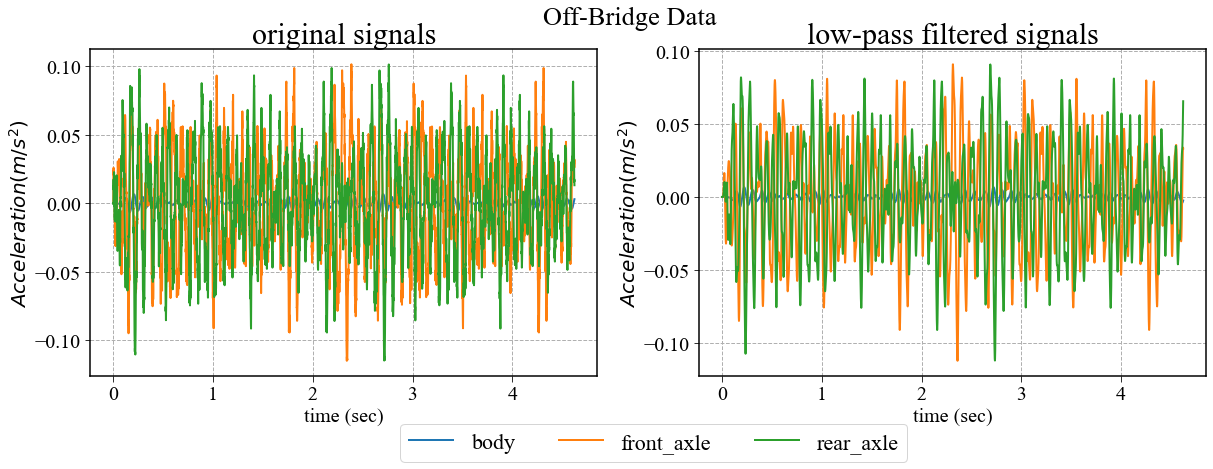

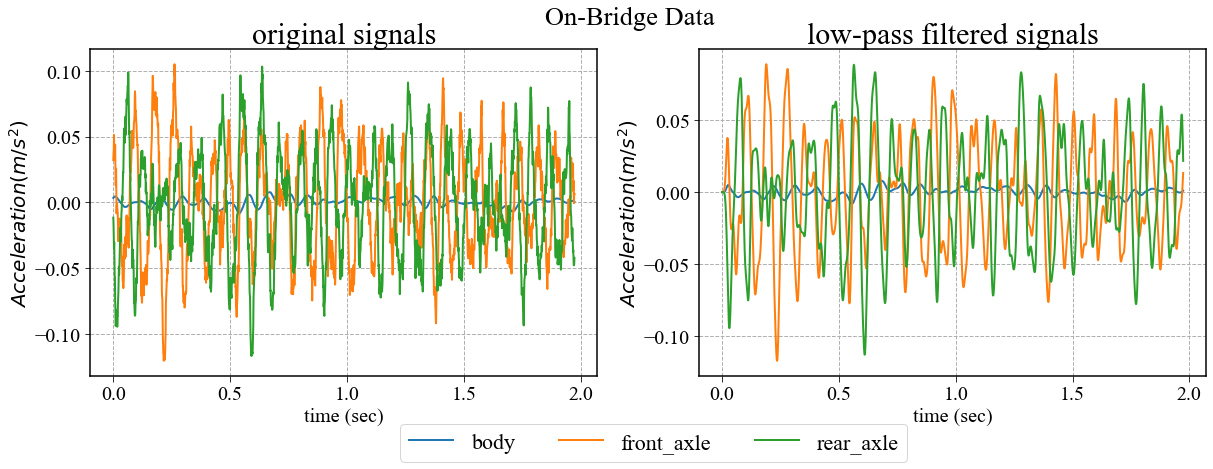

In [63]:

# off-bridge:
fig,axs = plt.subplots(1,2,figsize=(20,6))
axs[0].plot(time_off,sig_mat_off);axs[0].set_title('original signals');axs[0].legend(col_labs[1:],loc='lower right',ncol=len(col_labs[1:]),bbox_transform=fig.transFigure,bbox_to_anchor=(0.7,-0.1))
axs[0].set_xlabel('time (sec)'); axs[0].set_ylabel(r'$Acceleration ({m/s^2})$')
axs[1].plot(time_off,filt_sig_off); axs[1].set_title('low-pass filtered signals')
axs[1].set_xlabel('time (sec)'); axs[1].set_ylabel(r'$Acceleration ({m/s^2})$')
fig.suptitle('Off-Bridge Data')
# on-bridge:
fig,axs = plt.subplots(1,2,figsize=(20,6))
axs[0].plot(time_on,sig_mat_on);axs[0].set_title('original signals');axs[0].legend(col_labs[1:],loc='lower right',ncol=len(col_labs[1:]),bbox_transform=fig.transFigure,bbox_to_anchor=(0.7,-0.1))
axs[0].set_xlabel('time (sec)'); axs[0].set_ylabel(r'$Acceleration ({m/s^2})$')
axs[1].plot(time_on,filt_sig_on); axs[1].set_title('low-pass filtered signals')
axs[1].set_xlabel('time (sec)'); axs[1].set_ylabel(r'$Acceleration ({m/s^2})$')
fig.suptitle('On-Bridge Data')


### Plot psd of low-pass filtered signals:

1974
[0.  0.1]


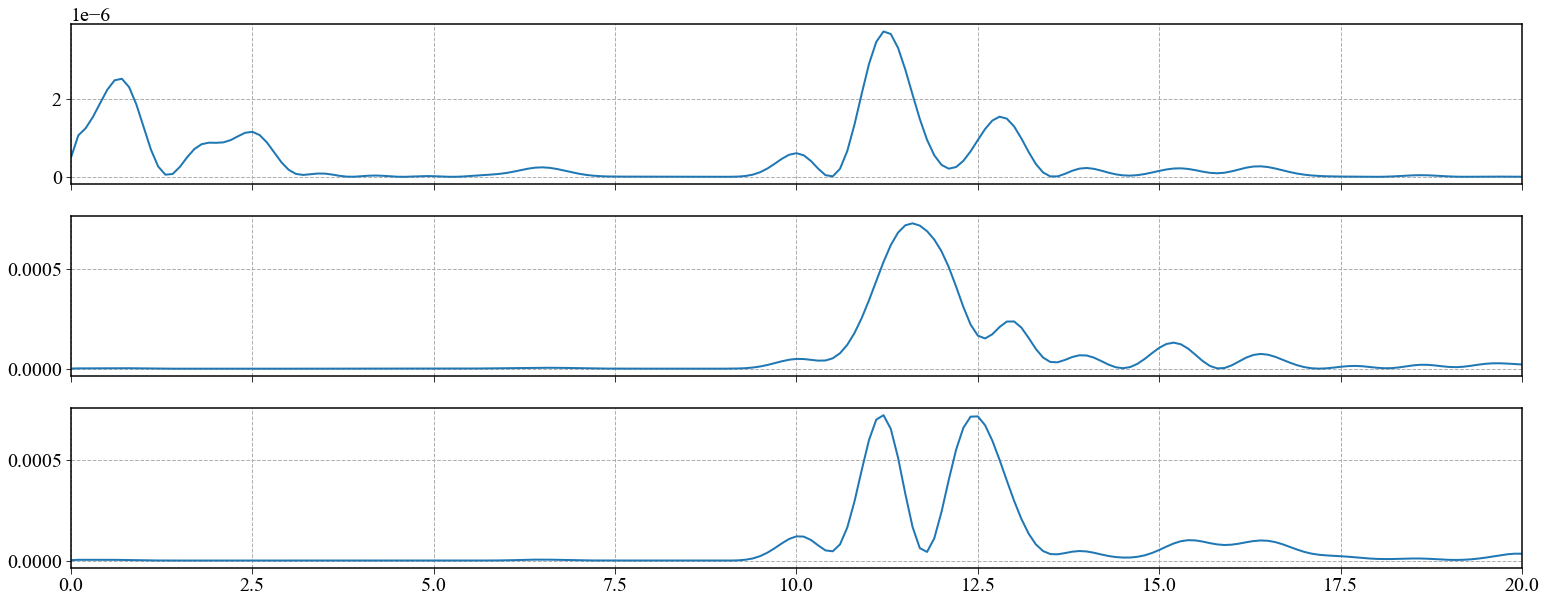

In [65]:
f_on,psd_sig_on = get_psd_welch(sig_mat_on,freq_res,fs)
print(f_on[0:2])
fig,axs = plt.subplots(num_sensors,1,sharex=True,figsize=(26,10))
for idx,ax in enumerate(axs):
    sns.lineplot(x=f_on,y=psd_sig_on[:,idx],ax=ax)
    ax.set_xlim([0,20])

## Filtering vehicle-dominant frequency:
### Extract optimum VMD parameters using off-bridge data:

In [66]:
opt_mode_off,opt_alpha_off = [],[]
opt_mode_on,opt_alpha_on = [],[]
sig_params_opt = {
                'fs':fs,
                'low_freq':low_freq,
                'num_peaks':1,
                'freq_res':freq_res,
}
for sens in range(num_sensors):
    opt_mode_temp, opt_alpha_temp = get_opt_vmd_params (filt_sig_off[:,sens],[100,1000],[2,6],sig_params_opt)
    opt_mode_off.append(opt_mode_temp)
    opt_alpha_off.append(opt_alpha_temp)
    opt_mode_temp, opt_alpha_temp = get_opt_vmd_params (filt_sig_on[:,sens],[100,1000],[2,6],sig_params_opt)
    opt_mode_on.append(opt_mode_temp)
    opt_alpha_on.append(opt_alpha_temp)

### Decompose off-bridge data using optimum vmd parameters:

In [67]:
dec_sig_off,dec_sig_on = [],[]
for i in range(num_sensors):
    dec_sig_off.append(dec_vmd(filt_sig_off[:,i],1000,0,5))
    dec_sig_on.append(dec_vmd(filt_sig_on[:,i],1000,0,5))

### Select first mode:

In [12]:
# off-bridge:
sel_dec_off = np.zeros((len(time_off),num_sensors))
sel_dec_on= np.zeros((len(time_on),num_sensors))
for count,sig_mat in enumerate(dec_sig_off):
    sel_dec_off[:,count] = sig_mat[0]
    sel_dec_on[:,count] = dec_sig_on[count][0]

### Compute power spectrum for off-bridge data:

In [13]:
# off-bridge:
# preallocate lists to store psd matrices of decomposed signals:
f,sel_psd_off = get_psd_welch(sel_dec_off,freq_res,fs)
max_psd_off = np.max(sel_psd_off,axis=0)
idx_max_psd_off = np.argmax(sel_psd_off,axis=0)
df_veh_dom = pd.DataFrame({'peak_f': f[idx_max_psd_off],'peak_psd':max_psd_off})
df_veh_dom

,peak_f,peak_psd
0,10.4,3.294610e-08
1,10.0,4.449354e-06
2,10.0,5.253666e-06


### Compute peak widths:

In [14]:
p_widths = [peak_widths(sel_psd_off[:,count].T, [idx], rel_height=0.8) for count, idx in enumerate(idx_max_psd_off)]
f_low = [int(np.floor(p_widths[i][-2])) for i in range(num_sensors)] # lower frequency
f_up = [int(np.floor(p_widths[i][-1])) for i in range(num_sensors)] # upper frequency
f_bounds = [f[f_low],f[f_up]]
print(f_bounds)

[array([9.7, 9.7, 9.7]), array([10.5, 10.1, 10.5])]


## Filter out dominant vehicle frequency
### Execute bandstop filter for off and on bridge data:

In [15]:
# off-bridge:
sig_final_off = np.zeros(sel_dec_off.shape)
for i in range(num_sensors):
    sig_final_off[:,i] = butter_filter(sel_dec_off[:,i], [f_bounds[0][i],f_bounds[1][i]], 'bandstop', fs, 8)
# on-bridge:
sig_final_on = np.zeros(sel_dec_on.shape)
for i in range(num_sensors):
    sig_final_on[:,i] = butter_filter(sel_dec_on[:,i], [f_bounds[0][i],f_bounds[1][i]], 'bandstop', fs, 8)

### Plot bandstop filter:

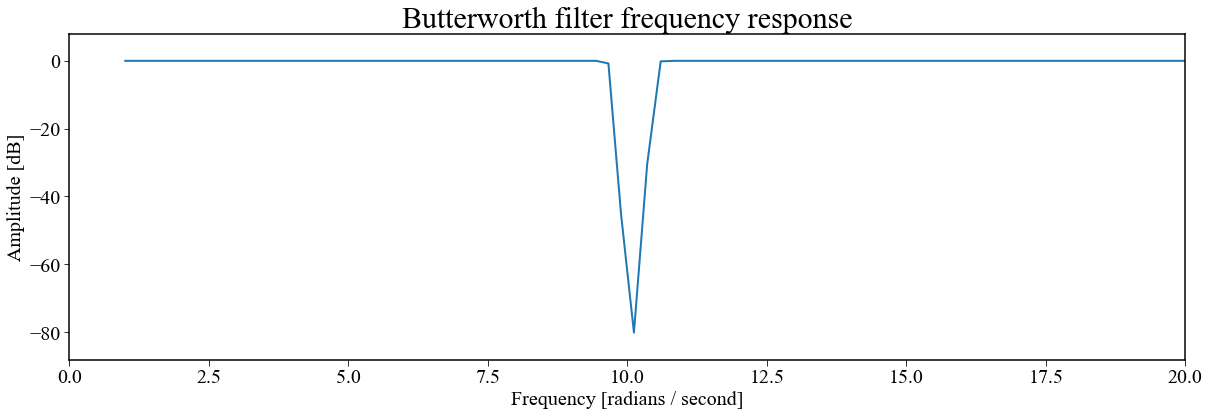

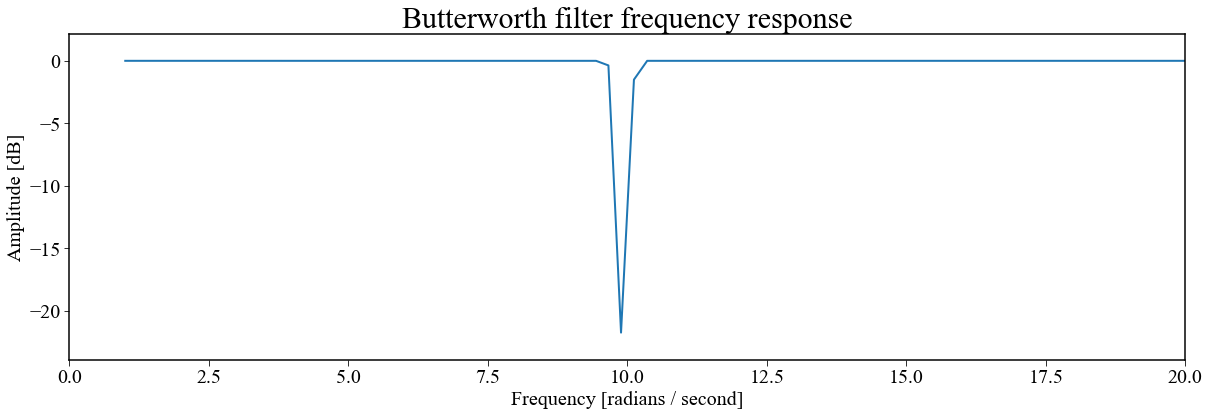

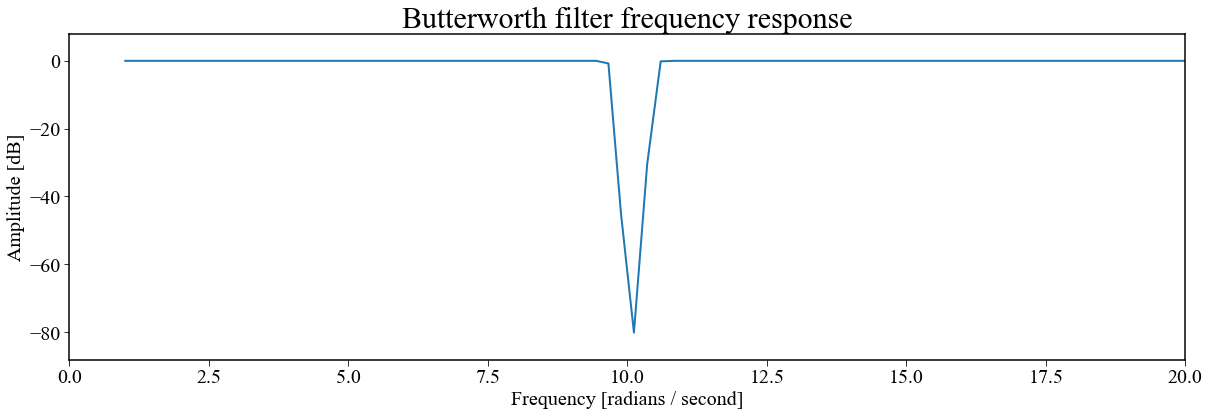

In [16]:
for i in range(num_sensors):
    fig = plt.figure(figsize=(20,6))
    b,a = signal.butter(8, [f_bounds[0][i],f_bounds[1][i]], 'bandstop',analog=True)
    w, h = signal.freqs(b,a)
    plt.plot(w, 20 * np.log10(abs(h)))
    plt.xlim([0,20])
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(100, color='green') # cutoff frequency


#### Plot signals after vehicle frequency filter

Text(0.5, 0.98, 'On-bridge')

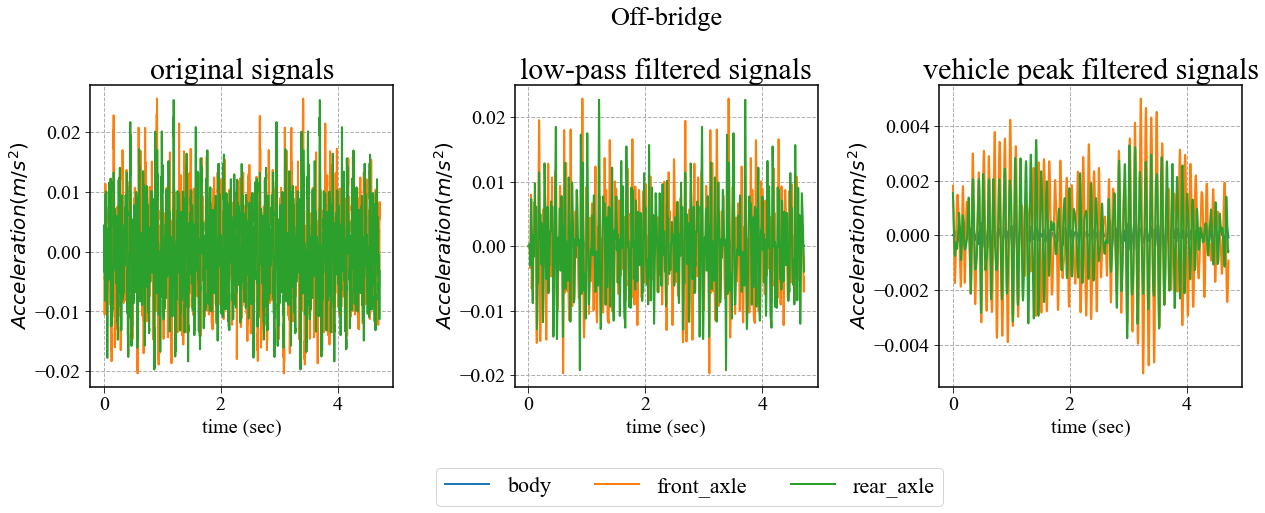

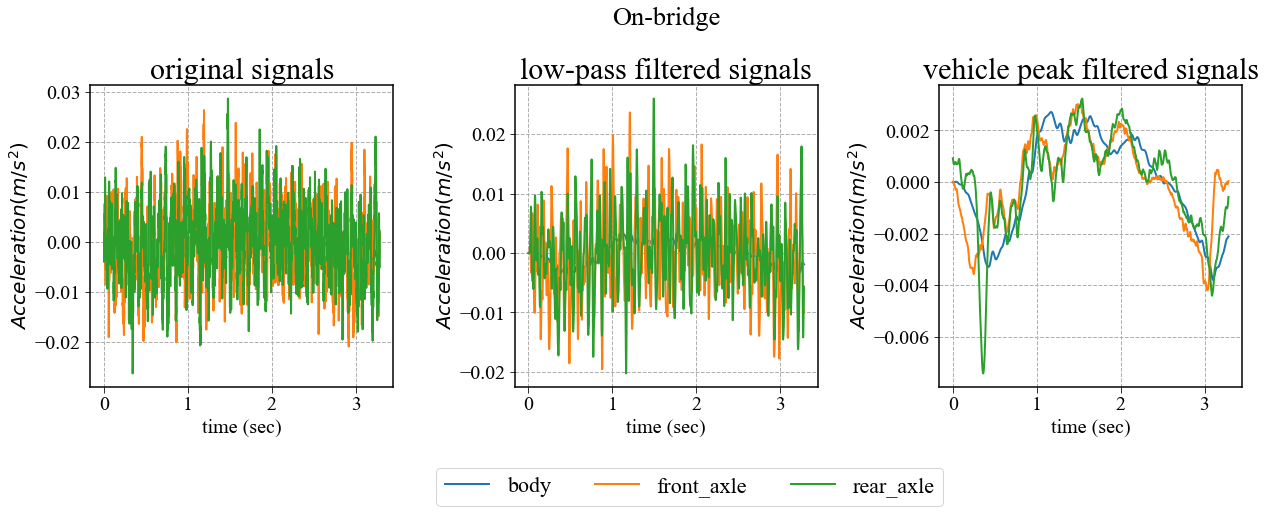

In [17]:
# Off-bridge:
fig,axs = plt.subplots(1,3,figsize=(20,6))
axs[0].plot(time_off,sig_mat_off);axs[0].set_title('original signals');axs[0].legend(col_labs[1:],loc='lower right',ncol=len(col_labs[1:]),bbox_transform=fig.transFigure,bbox_to_anchor=(0.7,-0.2))
axs[0].set_xlabel('time (sec)'); axs[0].set_ylabel(r'$Acceleration ({m/s^2})$')
axs[1].plot(time_off,filt_sig_off); axs[1].set_title('low-pass filtered signals')
axs[1].set_xlabel('time (sec)'); axs[1].set_ylabel(r'$Acceleration ({m/s^2})$')
axs[2].plot(time_off,sig_final_off); axs[2].set_title('vehicle peak filtered signals')
axs[2].set_xlabel('time (sec)'); axs[2].set_ylabel(r'$Acceleration ({m/s^2})$')
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.8,wspace=0.4,hspace=0.4)
fig.suptitle('Off-bridge')
# On-bridge:
fig,axs = plt.subplots(1,3,figsize=(20,6))
axs[0].plot(time_on,sig_mat_on);axs[0].set_title('original signals');axs[0].legend(col_labs[1:],loc='lower right',ncol=len(col_labs[1:]),bbox_transform=fig.transFigure,bbox_to_anchor=(0.7,-0.2))
axs[0].set_xlabel('time (sec)'); axs[0].set_ylabel(r'$Acceleration ({m/s^2})$')
axs[1].plot(time_on,filt_sig_on); axs[1].set_title('low-pass filtered signals')
axs[1].set_xlabel('time (sec)'); axs[1].set_ylabel(r'$Acceleration ({m/s^2})$')
axs[2].plot(time_on,sig_final_on); axs[2].set_title('vehicle peak filtered signals')
axs[2].set_xlabel('time (sec)'); axs[2].set_ylabel(r'$Acceleration ({m/s^2})$')
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.8,wspace=0.4,hspace=0.4)
fig.suptitle('On-bridge')


### Compute vehicle-filtered PSD

In [18]:
# Off-bridge:
f,psd_final_off = get_psd_welch(sig_final_off,freq_res,fs)
# On-bridge:
f,psd_final_on = get_psd_welch(sig_final_on,freq_res,fs)

### Peak picking:

In [19]:
# off-bridge:
peak_psd_off,peak_f_off = get_peaks(f,psd_final_off,num_peaks)
print(f'The peak psd and corresponder frequency values are {peak_psd_off} and {peak_f_off}, respectively.')
# on-bridge:
peak_psd_on,peak_f_on = get_peaks(f,psd_final_on,num_peaks)
print(f'The peak psd and corresponder frequency values are {peak_psd_on} and {peak_f_on}, respectively.')


The peak psd and corresponder frequency values are [array([3.48168515e-08, 1.76378064e-08, 9.50029365e-09, 8.60689261e-09,
       8.43397882e-09]), array([4.70171113e-06, 3.16605294e-06, 2.16506107e-06, 1.03614850e-06]), array([3.48828110e-06, 1.44033102e-06, 7.78483247e-07])] and [array([10.7, 11.2, 14. , 13.6, 14.3]), array([10.4, 10.8, 11.2, 11.6]), array([10.7, 11.2, 11.7])], respectively.
The peak psd and corresponder frequency values are [array([6.38544904e-06]), array([4.72882274e-06, 8.98981638e-07]), array([4.45200149e-06, 9.63435466e-07])] and [array([0.2]), array([0.2, 1.9]), array([0.2, 1.9])], respectively.


### Plot PSD with peaks:

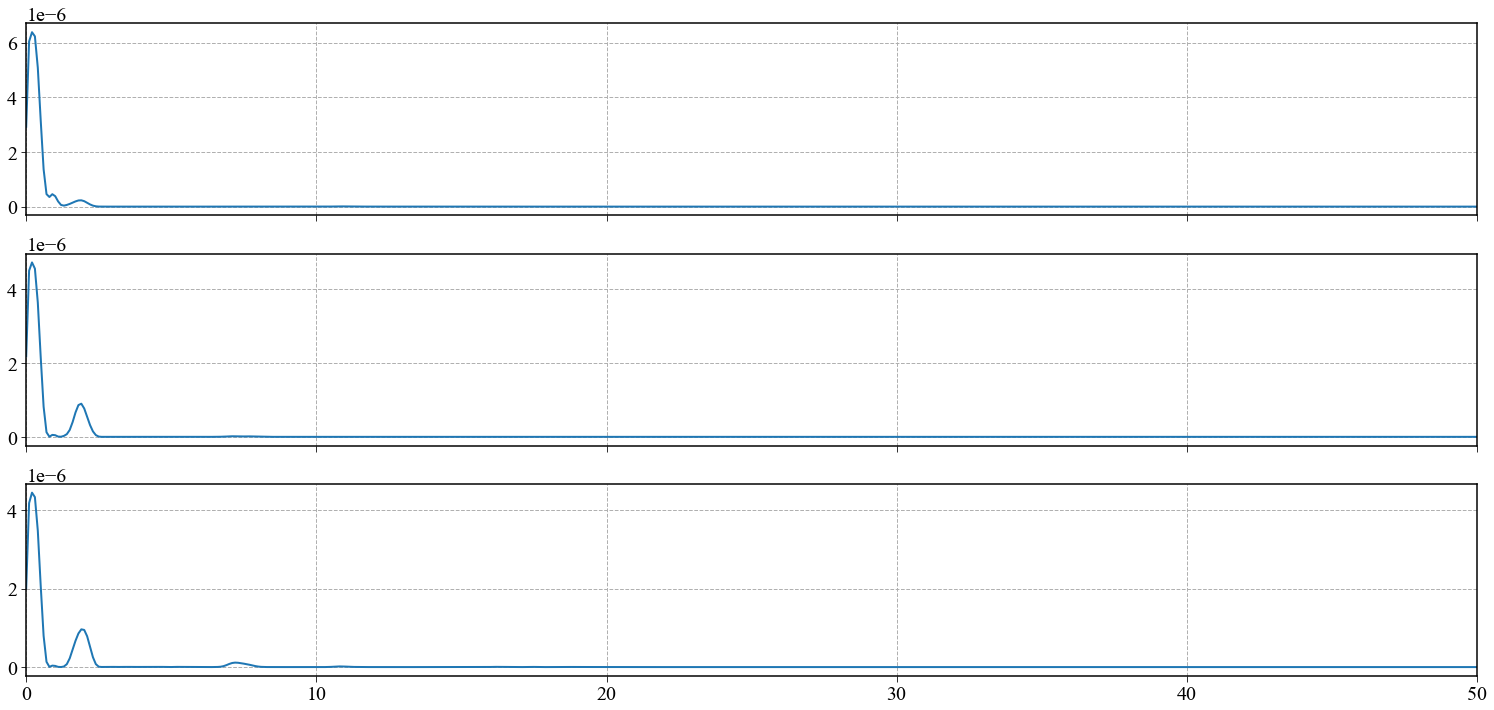

In [20]:
fig,axs = plt.subplots(num_sensors,1,sharex=True,figsize=(26,12))
for idx,ax in enumerate(axs):
    sns.lineplot(x=f,y=psd_final_on[:,idx],ax=ax)
    plt.xlim([0,50])

### Store final results in dataframe
Nested loops through nested peak psd lists and store each element with its corresponding mode number, sensor, and on-bridge binary int for off-bridge

In [39]:
res_dict = {'peak_f':[],'peak_psd':[],'sensor':[],'on_bridge':[]}
for idx_out,p_psd in enumerate(peak_psd_off):
    for idx_in,elem in enumerate(p_psd):
        res_dict['peak_f'].append(peak_f_off[idx_out][idx_in])
        res_dict['peak_psd'].append(elem)
        res_dict['sensor'].append(col_labs[idx_out+1])
        res_dict['on_bridge'].append(0)
df_off = pd.DataFrame(res_dict)
df_off

,peak_f,peak_psd,sensor,on_bridge
0,10.7,3.481685e-08,body,0
1,11.2,1.763781e-08,body,0
2,14.0,9.500294e-09,body,0
3,13.6,8.606893e-09,body,0
4,14.3,8.433979e-09,body,0
5,10.4,4.701711e-06,front_axle,0
6,10.8,3.166053e-06,front_axle,0
7,11.2,2.165061e-06,front_axle,0
8,11.6,1.036149e-06,front_axle,0
9,10.7,3.488281e-06,rear_axle,0


Nested loops through nested peak psd lists and store each element with its corresponding mode number, sensor, and on-bridge binary int for on-bridge

In [40]:
res_dict = {'peak_f':[],'peak_psd':[],'sensor':[],'on_bridge':[]}
for idx_out,p_psd in enumerate(peak_psd_on):
    for idx_in,elem in enumerate(p_psd):
        res_dict['peak_f'].append(peak_f_on[idx_out][idx_in])
        res_dict['peak_psd'].append(elem)
        res_dict['sensor'].append(col_labs[idx_out+1])
        res_dict['on_bridge'].append(1)
df_on = pd.DataFrame(res_dict)
df_on

,peak_f,peak_psd,sensor,on_bridge
0,0.2,6.385449e-06,body,1
1,0.2,4.728823e-06,front_axle,1
2,1.9,8.989816e-07,front_axle,1
3,0.2,4.452001e-06,rear_axle,1
4,1.9,9.634355e-07,rear_axle,1


### Concatenate dataframes into one dataframes

In [ ]:
df_final = pd.concat((df_off,df_on))
df_final.reset_index(inplace=True,drop=True)
df_final